# ROMY Events - Plots Ratio

In [1]:
import os
import gc
import obspy as obs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from andbro__store_as_pickle import __store_as_pickle

from functions.get_median import __get_median
from functions.get_percentiles import __get_percentiles


In [2]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
    bay_path = '/home/andbro/bay200/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'
elif os.uname().nodename == 'lin-ffb-01':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'

### Configurations

In [3]:
config = {}

# path to data
config['path_to_data'] = data_path+"romy_events/data/"

config['path_to_figs'] = data_path+"romy_events/figures/"

config['path_to_mseed'] = data_path+"romy_events/data/waveforms/ACC/"

# specify event file
# config['eventfile'] = "ROMYevents_2020_2023_status.csv"
config['eventfile'] = "ROMYevents_2019_2024_status.csv"

# specify catalog
config['catalogfile'] = "catalogs/ROMY_global_catalog_20200101_20231231.pkl"

# ROMY coordinates
config['sta_lon'] = 11.275501
config['sta_lat'] = 48.162941


### Load Catalog

In [4]:
select_z =  pd.read_pickle(config['path_to_data']+config['eventfile'].split('.')[0]+"_select_z.pkl")

### Load Amplitudes

In [5]:
# specify amplitude type
amp_type = "perc95" # envelope maxima  perc95  mean

amp = pd.read_pickle(config['path_to_data']+f"amplitudes_{amp_type}.pkl")


In [6]:
amp.keys()

dict_keys(['002', '005', '018', '022', '023', '024', '026', '031', '042', '048', '060', '064', '083', '182', '185', '189', '190', '196', '198', '199', '243', '256', '260', '307', '328', '343', '345', '352', '369', '374', '397', '404', '405', '406', '416', '421', '423', '435', '440', '465', '468', '488', '489', '490', '499', '502'])

### Load Spectra

In [7]:
spec = pd.read_pickle(config['path_to_data']+f"spectra.pkl")

## Plot Amplitudes

In [8]:
romy_z = {}
rlas_z = {}
fur_z = {}
wet_z = {}

# extract frequency bands
fbands = list(amp['002'].keys())

# fill dictionary with array for romy and rlas for all events with fband keys
for fband in fbands:
    romy_z[str(fband)] = []
    rlas_z[str(fband)] = []
    fur_z[str(fband)] = []
    wet_z[str(fband)] = []

    try:
        for evn in amp.keys():
            romy_z[str(fband)].append(amp[evn][fband]['ROMY.BJZ'])
            rlas_z[str(fband)].append(amp[evn][fband]['RLAS.BJZ'])
            fur_z[str(fband)].append(amp[evn][fband]['FUR.BHT'])
            wet_z[str(fband)].append(amp[evn][fband]['WET.BHT'])
    except:
        continue

# create lists of all maxima for plotting
romy_z_arr = []
rlas_z_arr = []
fur_z_arr = []
wet_z_arr = []

for fband in fbands:
    romy_z_arr.append(romy_z[str(fband)])
    rlas_z_arr.append(rlas_z[str(fband)])
    fur_z_arr.append(fur_z[str(fband)])
    wet_z_arr.append(wet_z[str(fband)])

# create lists of all maxima for plotting
romy_z_arr = np.array(romy_z_arr)
rlas_z_arr = np.array(rlas_z_arr)
fur_z_arr = np.array(fur_z_arr)
wet_z_arr = np.array(wet_z_arr)

romy_z_med = __get_median(romy_z_arr.T)
rlas_z_med = __get_median(rlas_z_arr.T)
fur_z_med = __get_median(fur_z_arr.T)
wet_z_med = __get_median(wet_z_arr.T)

plower, pupper = 20, 80
romy_z_plower, romy_z_pupper = __get_percentiles(romy_z_arr.T, p_low=plower, p_high=pupper)
rlas_z_plower, rlas_z_pupper = __get_percentiles(rlas_z_arr.T, p_low=plower, p_high=pupper)
fur_z_plower, fur_z_pupper = __get_percentiles(fur_z_arr.T, p_low=plower, p_high=pupper)
wet_z_plower, wet_z_pupper = __get_percentiles(wet_z_arr.T, p_low=plower, p_high=pupper)

In [9]:
print("Event Count: ", np.shape(fur_z_arr)[1])

Event Count:  46


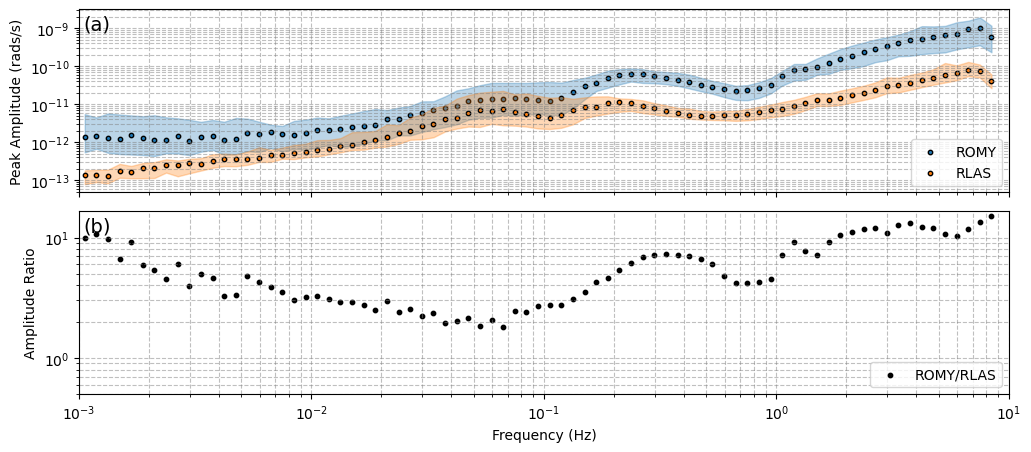

In [10]:
def __makeplot():

    import matplotlib.pyplot as plt

    Nrow, Ncol = 2, 1

    font = 12

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(12, 5), sharex=True)

    plt.subplots_adjust(hspace=0.1)

#     perc = 50

#     m_rlas, m_romy = [], []

#     e_upper, e_lower = [], []


    ax[0].fill_between(fbands, romy_z_plower, romy_z_pupper, color="tab:blue", alpha=0.3)
    ax[0].scatter(fbands, romy_z_med, label="ROMY",
                  s=10, color="tab:blue", edgecolor="k",
                  )


    ax[0].fill_between(fbands, rlas_z_plower, rlas_z_pupper, color="tab:orange", alpha=0.3)
    ax[0].scatter(fbands, rlas_z_med, label="RLAS",
                  s=10, color="tab:orange", edgecolor="k",
                  )


    ax[1].scatter(fbands, romy_z_med/rlas_z_med, label="ROMY/RLAS",
                  s=10, color="black", edgecolor="k",
                  )

#     for _i, (fb, r1) in enumerate(zip(fbands, romy_z_arr)):

#         if _i == 0:
#             ax[0].errorbar(fb, np.nanmedian(r1), yerr=np.nanstd(r1), label="ROMY",
#                            fmt="o", markersize=3, color="tab:blue", markeredgecolor="k",
#                           )
#         else:
#             ax[0].errorbar(fb, np.nanmedian(r1), yerr=np.nanstd(r1),
#                            fmt="o", markersize=3, color="tab:blue", markeredgecolor="k",
#                           )

#         e_upper.append(np.nanmedian(r1)+np.nanstd(r1))
#         e_lower.append(np.nanmedian(r1)-np.nanstd(r1))
#         # e_upper.append(np.nanpercentile(r1, perc))
#         # e_lower.append(np.nanpercentile(r1, perc))
#         m_romy.append(np.nanmedian(r1))

#     e_upper, e_lower = [], []
#     for _i, (fb, r1) in enumerate(zip(fbands, rlas_z_arr)):

#         if _i == 0:
#             ax[0].errorbar(fb, np.nanmedian(r1), yerr=np.nanstd(r1), label="RLAS",
#                            fmt="o", markersize=3, color="tab:orange", markeredgecolor="k",
#                           )
#         else:
#             ax[0].errorbar(fb, np.nanmedian(r1), yerr=np.nanstd(r1),
#                            fmt="o", markersize=3, color="tab:orange", markeredgecolor="k",
#                           )

#         e_upper.append(np.nanmedian(r1)+np.nanstd(r1))
#         e_lower.append(np.nanmedian(r1)-np.nanstd(r1))
#         # e_upper.append(np.nanpercentile(r1, perc))
#         # e_lower.append(np.nanpercentile(r1, perc))
#         m_rlas.append(np.nanmedian(r1))


    # ax[1].scatter(fbands, np.array(m_romy)/np.array(m_rlas), s=7, color="k", label="ROMY/RLAS")

    for _k in range(Nrow):
        ax[_k].legend(loc=4)
        ax[_k].grid(which="both", ls="--", color="grey", alpha=0.5, zorder=0)
        ax[_k].set_xscale("log")
        ax[_k].set_yscale("log")
        ax[_k].set_xlim(1e-3, 10)

    ax[0].set_ylabel("Peak Amplitude (rads/s)")
    ax[1].set_ylabel("Amplitude Ratio")
    ax[1].set_xlabel("Frequency (Hz)")

    ax[1].set_ylim(bottom=0.5)

    ax[0].text(.005, .97, "(a)", ha='left', va='top', transform=ax[0].transAxes, fontsize=font+2)
    ax[1].text(.005, .97, "(b)", ha='left', va='top', transform=ax[1].transAxes, fontsize=font+2)

    plt.show();
    return fig

fig = __makeplot();


fig.savefig(config['path_to_figs']+f"RomyEvents_Amplitude_Ratio_RomyRlas_{amp_type}.png", format="png", dpi=150, bbox_inches='tight')


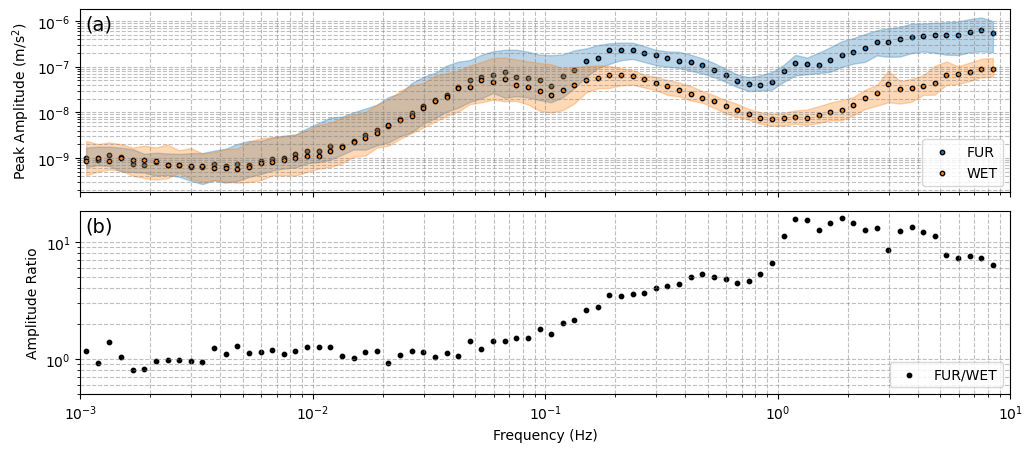

In [11]:
def __makeplot():

    import matplotlib.pyplot as plt

    Nrow, Ncol = 2, 1

    font = 12

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(12, 5), sharex=True)

    plt.subplots_adjust(hspace=0.1)


    ax[0].fill_between(fbands, fur_z_plower, fur_z_pupper, color="tab:blue", alpha=0.3)
    ax[0].scatter(fbands, fur_z_med, label="FUR",
                  s=10, color="tab:blue", edgecolor="k",
                  )


    ax[0].fill_between(fbands, wet_z_plower, wet_z_pupper, color="tab:orange", alpha=0.3)
    ax[0].scatter(fbands, wet_z_med, label="WET",
                  s=10, color="tab:orange", edgecolor="k",
                  )


    ax[1].scatter(fbands, fur_z_med/wet_z_med, label="FUR/WET",
                  s=10, color="black", edgecolor="k",
                  )

#     perc = 70

#     m_rlas, m_romy = [], []

#     e_upper, e_lower = [], []

#     for _i, (fb, r1) in enumerate(zip(fbands, fur_z_arr)):

#         if _i == 0:
#             ax[0].errorbar(fb, np.nanmedian(r1), yerr=np.nanstd(r1), label="FUR",
#                            fmt="o", markersize=3, color="tab:blue", markeredgecolor="k",
#                           )
#         else:
#             ax[0].errorbar(fb, np.nanmedian(r1), yerr=np.nanstd(r1),
#                            fmt="o", markersize=3, color="tab:blue", markeredgecolor="k",
#                           )

#         ax[0].fill_between(fbands, romy_z_plower, romy_z_pupper, color="tab:blue", alpha=0.3)

#         e_upper.append(np.nanmedian(r1)+np.nanstd(r1))
#         e_lower.append(np.nanmedian(r1)-np.nanstd(r1))
#         # e_upper.append(np.nanpercentile(r1, perc))
#         # e_lower.append(np.nanpercentile(r1, perc))
#         m_romy.append(np.nanmedian(r1))

#     e_upper, e_lower = [], []
#     for _i, (fb, r1) in enumerate(zip(fbands, wet_z_arr)):

#         if _i == 0:
#             ax[0].errorbar(fb, np.nanmedian(r1), yerr=np.nanstd(r1), label="WET",
#                            fmt="o", markersize=3, color="tab:orange", markeredgecolor="k",
#                           )
#         else:
#             ax[0].errorbar(fb, np.nanmedian(r1), yerr=np.nanstd(r1),
#                            fmt="o", markersize=3, color="tab:orange", markeredgecolor="k",
#                           )

#         e_upper.append(np.nanmedian(r1)+np.nanstd(r1))
#         e_lower.append(np.nanmedian(r1)-np.nanstd(r1))
#         # e_upper.append(np.nanpercentile(r1, perc))
#         # e_lower.append(np.nanpercentile(r1, perc))
#         m_rlas.append(np.nanmedian(r1))


#     ax[1].scatter(fbands, np.array(m_romy)/np.array(m_rlas), s=7, color="k", label="FUR/WET")

    for _k in range(Nrow):
        ax[_k].legend(loc=4)
        ax[_k].grid(which="both", ls="--", color="grey", alpha=0.5, zorder=0)
        ax[_k].set_xscale("log")
        ax[_k].set_yscale("log")
        ax[_k].set_xlim(1e-3, 10)

    ax[0].set_ylabel("Peak Amplitude (m/s$^2$)")
    ax[1].set_ylabel("Amplitude Ratio")
    ax[1].set_xlabel("Frequency (Hz)")

    ax[1].set_ylim(bottom=0.5)

    ax[0].text(.005, .97, "(a)", ha='left', va='top', transform=ax[0].transAxes, fontsize=font+2)
    ax[1].text(.005, .97, "(b)", ha='left', va='top', transform=ax[1].transAxes, fontsize=font+2)

    plt.show();
    return fig

fig = __makeplot();


fig.savefig(config['path_to_figs']+f"RomyEvents_Amplitude_Ratio_FURWET_{amp_type}.png", format="png", dpi=150, bbox_inches='tight')


## Spectra

In [12]:
spec['002']['freq']

array([8.91250938e-05, 1.77827941e-04, 2.66072506e-04, 3.54813389e-04,
       4.46683592e-04, 5.30884444e-04, 7.07945784e-04, 7.94328235e-04,
       8.91250938e-04, 1.05925373e-03, 1.25892541e-03, 1.33352143e-03,
       1.41253754e-03, 1.49623566e-03, 1.58489319e-03, 1.67880402e-03,
       1.77827941e-03, 1.88364909e-03, 2.11348904e-03, 2.23872114e-03,
       2.37137371e-03, 2.51188643e-03, 2.66072506e-03, 2.81838293e-03,
       2.98538262e-03, 3.16227766e-03, 3.34965439e-03, 3.54813389e-03,
       3.75837404e-03, 3.98107171e-03, 4.21696503e-03, 4.46683592e-03,
       4.73151259e-03, 5.01187234e-03, 5.30884444e-03, 5.62341325e-03,
       5.95662144e-03, 6.30957344e-03, 6.68343918e-03, 7.07945784e-03,
       7.49894209e-03, 7.94328235e-03, 8.41395142e-03, 8.91250938e-03,
       9.44060876e-03, 1.00000000e-02, 1.05925373e-02, 1.12201845e-02,
       1.18850223e-02, 1.25892541e-02, 1.33352143e-02, 1.41253754e-02,
       1.49623566e-02, 1.58489319e-02, 1.67880402e-02, 1.77827941e-02,
      

In [13]:
spec_romy_z = []
spec_rlas_z = []
spec_fur_z = []
spec_wet_z = []

# extract frequency bands
# fbands = list(spec['002'].keys())
fbands = spec['002']['freq']

# fill dictionary with array for romy and rlas for all events with fband keys
for evn in spec.keys():
    spec_romy_z.append(spec[str(evn)]['ROMY_BJZ'])
    spec_rlas_z.append(spec[str(evn)]['RLAS_BJZ'])
    spec_fur_z.append(spec[str(evn)]['FUR_BHT'])
    spec_wet_z.append(spec[str(evn)]['WET_BHT'])

# create lists of all maxima for plotting
spec_romy_z_arr = np.array(spec_romy_z)
spec_rlas_z_arr = np.array(spec_rlas_z)
spec_fur_z_arr = np.array(spec_fur_z)
spec_wet_z_arr = np.array(spec_wet_z)


# median
spec_romy_z_med = __get_median(spec_romy_z_arr)
spec_rlas_z_med = __get_median(spec_rlas_z_arr)
spec_fur_z_med = __get_median(spec_fur_z_arr)
spec_wet_z_med = __get_median(spec_wet_z_arr)

plower, pupper = 20, 80
spec_romy_z_plower, spec_romy_z_pupper = __get_percentiles(spec_romy_z_arr, p_low=plower, p_high=pupper)
spec_rlas_z_plower, spec_rlas_z_pupper = __get_percentiles(spec_rlas_z_arr, p_low=plower, p_high=pupper)
spec_fur_z_plower, spec_fur_z_pupper = __get_percentiles(spec_fur_z_arr, p_low=plower, p_high=pupper)
spec_wet_z_plower, spec_wet_z_pupper = __get_percentiles(spec_wet_z_arr, p_low=plower, p_high=pupper)


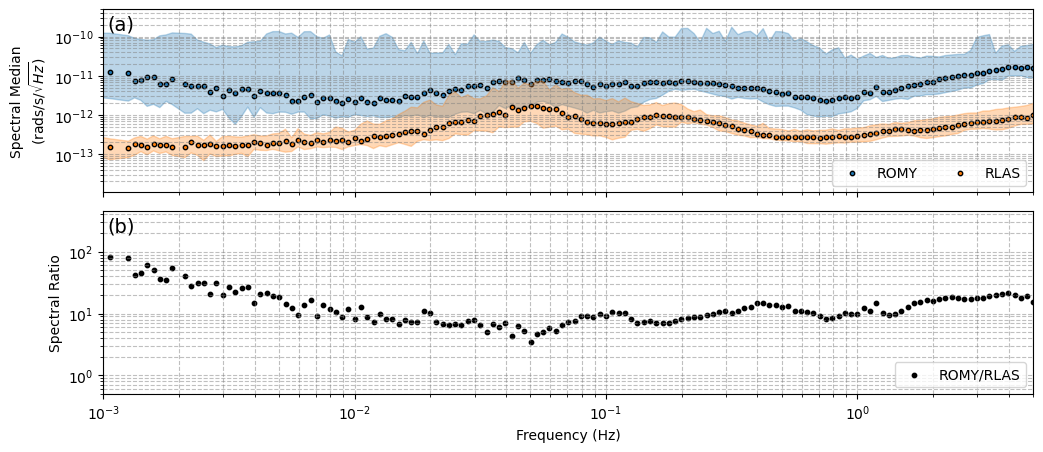

In [14]:
def __makeplot():

    import matplotlib.pyplot as plt

    Nrow, Ncol = 2, 1

    font = 12
    sqrt = r"$\sqrt{Hz}$"

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(12, 5), sharex=True)

    plt.subplots_adjust(hspace=0.1)


    ax[0].fill_between(fbands, spec_romy_z_plower, spec_romy_z_pupper, color="tab:blue", alpha=0.3)
    ax[0].scatter(fbands, spec_romy_z_med, label="ROMY",
                  s=10, color="tab:blue", edgecolor="k",
                  )


    ax[0].fill_between(fbands, spec_rlas_z_plower, spec_rlas_z_pupper, color="tab:orange", alpha=0.3)
    ax[0].scatter(fbands, spec_rlas_z_med, label="RLAS",
                  s=10, color="tab:orange", edgecolor="k",
                  )


    ax[1].scatter(fbands, spec_romy_z_med/spec_rlas_z_med, label="ROMY/RLAS",
                  s=10, color="black", edgecolor="k",
                  )

    for _k in range(Nrow):
        ax[_k].legend(loc=4, ncol=2)
        ax[_k].grid(which="both", ls="--", color="grey", alpha=0.5, zorder=0)
        ax[_k].set_xscale("log")
        ax[_k].set_yscale("log")
        ax[_k].set_xlim(1e-3, 5)


    ax[0].set_ylabel(f"Spectral Median\n(rads/s/{sqrt})")
    ax[1].set_ylabel("Spectral Ratio")
    ax[1].set_xlabel("Frequency (Hz)")

    ax[1].set_ylim(bottom=0.5)

    ax[0].text(.005, .97, "(a)", ha='left', va='top', transform=ax[0].transAxes, fontsize=font+2)
    ax[1].text(.005, .97, "(b)", ha='left', va='top', transform=ax[1].transAxes, fontsize=font+2)

    plt.show();
    return fig

fig = __makeplot();

fig.savefig(config['path_to_figs']+f"RomyEvents_Spectra_Ratio_ROMYRLAS.png", format="png", dpi=150, bbox_inches='tight')



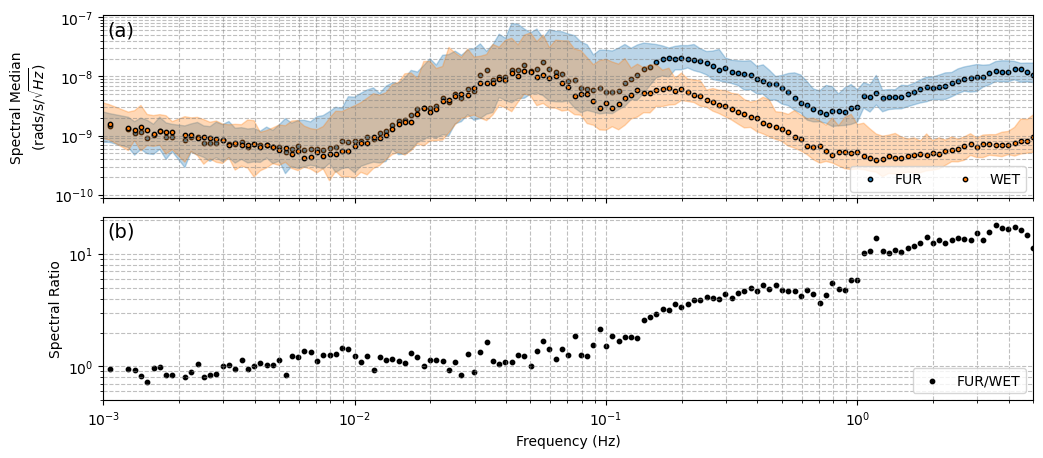

In [15]:
def __makeplot():

    import matplotlib.pyplot as plt

    Nrow, Ncol = 2, 1

    font = 12
    sqrt = r"$\sqrt{Hz}$"

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(12, 5), sharex=True)

    plt.subplots_adjust(hspace=0.1)


    ax[0].fill_between(fbands, spec_fur_z_plower, spec_fur_z_pupper, color="tab:blue", alpha=0.3)
    ax[0].scatter(fbands, spec_fur_z_med, label="FUR",
                  s=10, color="tab:blue", edgecolor="k",
                  )


    ax[0].fill_between(fbands, spec_wet_z_plower, spec_wet_z_pupper, color="tab:orange", alpha=0.3)
    ax[0].scatter(fbands, spec_wet_z_med, label="WET",
                  s=10, color="tab:orange", edgecolor="k",
                  )


    ax[1].scatter(fbands, spec_fur_z_med/spec_wet_z_med, label="FUR/WET",
                  s=10, color="black", edgecolor="k",
                  )

    for _k in range(Nrow):
        ax[_k].legend(loc=4, ncol=2)
        ax[_k].grid(which="both", ls="--", color="grey", alpha=0.5, zorder=0)
        ax[_k].set_xscale("log")
        ax[_k].set_yscale("log")
        ax[_k].set_xlim(1e-3, 5)


    ax[0].set_ylabel(f"Spectral Median\n(rads/s/{sqrt})")
    ax[1].set_ylabel("Spectral Ratio")
    ax[1].set_xlabel("Frequency (Hz)")

    ax[1].set_ylim(bottom=0.5)

    ax[0].text(.005, .97, "(a)", ha='left', va='top', transform=ax[0].transAxes, fontsize=font+2)
    ax[1].text(.005, .97, "(b)", ha='left', va='top', transform=ax[1].transAxes, fontsize=font+2)

    plt.show();
    return fig

fig = __makeplot();

fig.savefig(config['path_to_figs']+f"RomyEvents_Spectra_Ratio_FURWET.png", format="png", dpi=150, bbox_inches='tight')


In [16]:
def __select_frequency(dic, f=0.1):

    # select first event
    ev = list(dic.keys())[0]

    # select all frequencies
    freqs = np.array(list(dic[ev].keys()))

    # determine closest to request
    idx = np.absolute(freqs - f).argmin()
    val = freqs[idx]

    amp1 = {}
    amp2 = {}
    for k in dic.keys():
        amp1[k] = dic[k][val]["ROMY.BJZ"]
        amp2[k] = dic[k][val]["RLAS.BJZ"]

    return amp1, amp2, val

amp1_romyz, amp1_rlasz, fval = __select_frequency(amp, f=10)

/tmp/ipykernel_1569087/3958290973.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['ev_num'] = [str(int(_ev)).rjust(3, "0") for _ev in tmp['# Event']]
/tmp/ipykernel_1569087/3958290973.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['ev_num'] = [str(int(_ev)).rjust(3, "0") for _ev in tmp['# Event']]
/tmp/ipykernel_1569087/3958290973.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

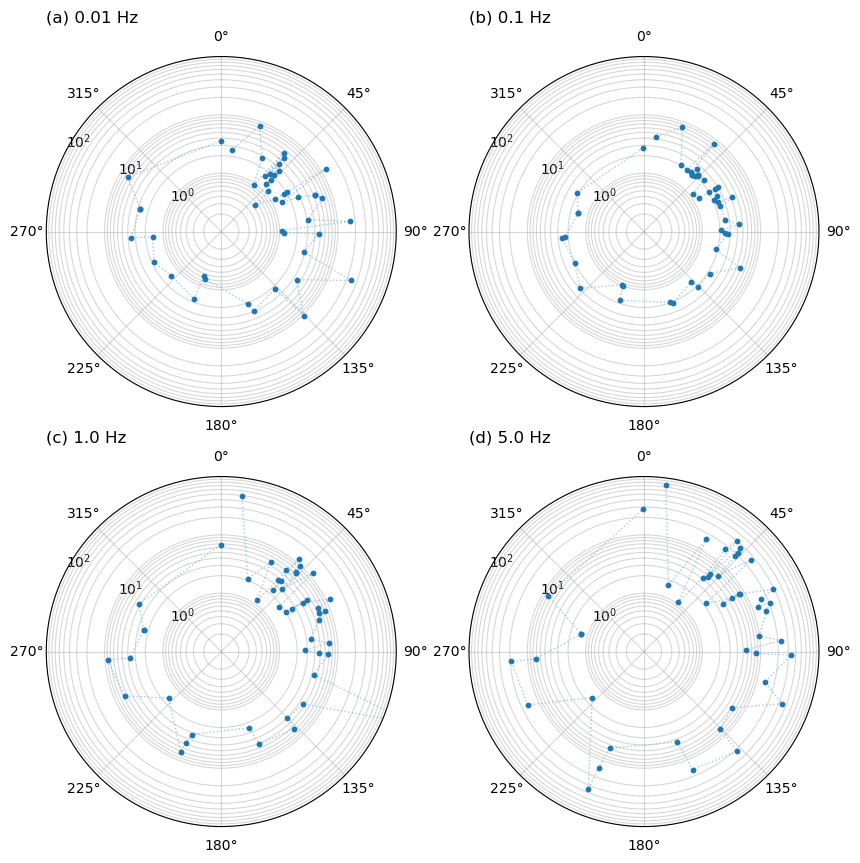

In [17]:
freqs = [0.01, 0.1, 1.0, 5.0]
rows = [0, 0, 1, 1]
cols = [0, 1, 0, 1]
lbl = ["(a)", "(b)", "(c)", "(d)"]

Nrow, Ncol = 2, 2

fig, ax = plt.subplots(Nrow, Ncol, figsize=(10, 10), subplot_kw={'projection': 'polar'})


for _n, (i, j, _f, _l) in enumerate(zip(rows, cols, freqs, lbl)):

    amp1_romyz, amp1_rlasz, fval = __select_frequency(amp, f=_f)

    # create new frame
    amp1_df = pd.DataFrame()
    amp1_df['ev_num'] = [str(_k) for _k in amp1_romyz.keys()]
    amp1_df['romyz'] = [_v for _v in amp1_romyz.values()]
    amp1_df['rlasz'] = [_v for _v in amp1_rlasz.values()]

    # select subset of event frame
    tmp = select_z[['# Event', 'backazimuth']]
    tmp['ev_num'] = [str(int(_ev)).rjust(3, "0") for _ev in tmp['# Event']]

    # merge frames based on event number
    amp1 = pd.merge(left=tmp, right=amp1_df, on="ev_num")

    amp1 = amp1.sort_values(by="backazimuth", ascending=True)

    ax[i, j].scatter(np.deg2rad(amp1.backazimuth), amp1.romyz/amp1.rlasz, s=10, zorder=2)
    ax[i, j].plot(np.deg2rad(amp1.backazimuth), amp1.romyz/amp1.rlasz, zorder=1, alpha=0.4, lw=1, ls=":")

    ax[i, j].grid(True, which="both", axis="both", zorder=0, alpha=0.5)
    ax[i, j].set_rscale("log")
    ax[i, j].set_rlabel_position(-62.5)
    ax[i, j].set_theta_zero_location("N")
    ax[i, j].set_theta_direction(-1)
    ax[i, j].set_rmin(1e-1)
    ax[i, j].set_rmax(1e2)

    ax[i, j].set_title(f"{_l} {_f} Hz", loc="left")

plt.show();

fig.savefig(config['path_to_figs']+f"RomyEvents_AmpRatio_Backazimuth.png", format="png", dpi=150, bbox_inches='tight')


In [18]:
amp1[amp1.ev_num == str(343)]['backazimuth'].iloc[0]

20.063638503024325

In [19]:
amp1

,# Event,backazimuth,ev_num,romyz,rlasz
23,307.0,7.496733,307,4.085900e-09,5.467023e-11
25,343.0,20.063639,343,2.222086e-10,1.345855e-10
40,465.0,29.048198,465,7.070147e-10,4.395352e-11
32,404.0,34.799837,404,1.243496e-10,1.173272e-10
36,421.0,38.482268,421,3.267391e-10,7.979561e-11
8,42.0,38.504120,042,7.457042e-10,4.287239e-11
16,190.0,40.106391,190,1.230416e-09,4.005724e-11
28,369.0,40.114352,369,9.994820e-10,1.789301e-10
41,468.0,40.397544,468,1.907803e-10,3.910894e-11
5,24.0,42.708422,024,1.027809e-09,3.898254e-11


0 0.01 (a)
1 0.1 (b)
2 1.0 (c)
3 5.0 (d)


/tmp/ipykernel_1569087/2400002825.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['ev_num'] = [str(int(_ev)).rjust(3, "0") for _ev in tmp['# Event']]
/tmp/ipykernel_1569087/2400002825.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['ev_num'] = [str(int(_ev)).rjust(3, "0") for _ev in tmp['# Event']]
/tmp/ipykernel_1569087/2400002825.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

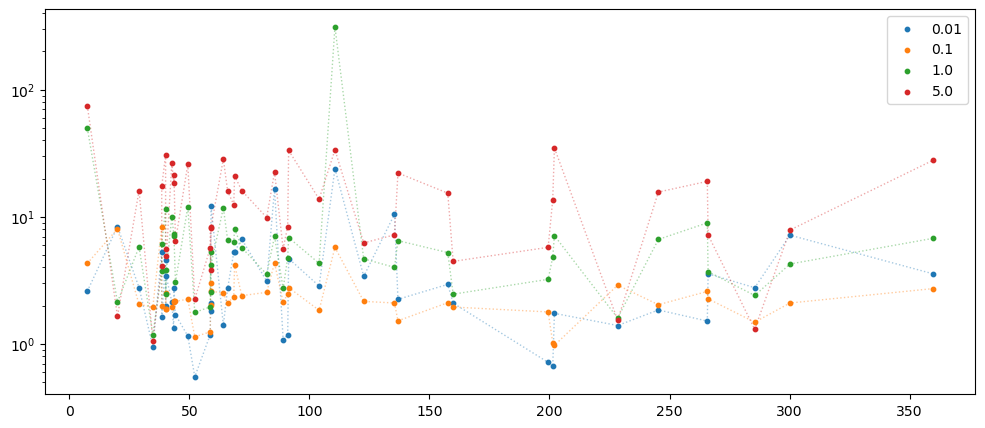

In [20]:
freqs = [0.01, 0.1, 1.0, 5.0]
rows = [0, 0, 1, 1]
cols = [0, 1, 0, 1]
lbl = ["(a)", "(b)", "(c)", "(d)"]

Nrow, Ncol = 1, 1

fig, ax = plt.subplots(Nrow, Ncol, figsize=(12, 5))

for _n, (_f, _l) in enumerate(zip(freqs, lbl)):

    print(_n, _f, _l)

    amp1_romyz, amp1_rlasz, fval = __select_frequency(amp, f=_f)

    # create new frame
    amp1_df = pd.DataFrame()
    amp1_df['ev_num'] = [str(_k) for _k in amp1_romyz.keys()]
    amp1_df['romyz'] = [_v for _v in amp1_romyz.values()]
    amp1_df['rlasz'] = [_v for _v in amp1_rlasz.values()]

    amp1_df['baz'] = [amp1[amp1.ev_num == str(num)]['backazimuth'].iloc[0] for num in amp1_df.ev_num]

    amp1_df['ratio'] = amp1_df.romyz/amp1_df.rlasz

    amp1_df.sort_values(by="baz", inplace=True)

    # select subset of event frame
    tmp = select_z[['# Event', 'backazimuth']]
    tmp['ev_num'] = [str(int(_ev)).rjust(3, "0") for _ev in tmp['# Event']]

    ax.scatter(amp1_df.baz, amp1_df.ratio, s=10, zorder=2, label=_f)
    ax.plot(amp1_df.baz, amp1_df.ratio, zorder=1, alpha=0.4, lw=1, ls=":")

ax.set_yscale("log")
ax.legend()

plt.show();
